In [7]:
import os

base_path = "/content/mlopstask"
os.makedirs(base_path, exist_ok=True)
os.chdir(base_path)

print("Current directory:", os.getcwd())

Current directory: /content/mlopstask


In [63]:
!pip install uvicorn

In [8]:
# Clone Github Repository
!git clone https://github.com/IBM/telco-customer-churn-on-icp4d

Cloning into 'telco-customer-churn-on-icp4d'...
remote: Enumerating objects: 252, done.
remote: Counting objects: 100% (110/110), done.
remote: Compressing objects: 100% (79/79), done.
remote: Total 252 (delta 26), reused 103 (delta 25), pack-reused 142 (from 1)
Receiving objects: 100% (252/252), 21.22 MiB | 20.58 MiB/s, done.
Resolving deltas: 100% (49/49), done.


In [9]:
# Core
import pandas as pd
import numpy as np
import json
import joblib
import warnings
warnings.filterwarnings("ignore")

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing & Modeling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, classification_report

# Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

# XGBoost
from xgboost import XGBClassifier

# Deployment
from fastapi import FastAPI

In [24]:
df = pd.read_csv("/content/mlopstask/telco-customer-churn-on-icp4d/data/Telco-Customer-Churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [25]:
# preview dataset last rows
df.tail()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes
7042,3186-AJIEK,Male,0,No,No,66,Yes,No,Fiber optic,Yes,...,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),105.65,6844.5,No


In [26]:
# Check for NULL values
df.isna().sum()

,0
customerID,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0


In [27]:
# Drop ID Column
df.drop("customerID", axis=1, inplace=True)

In [28]:
print("\nTarget Distribution:")
print(df['Churn'].value_counts(normalize=True))


Target Distribution:
Churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64


In [29]:
# Target encoding
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

In [31]:
# Handle TotalCharges if object
if df['TotalCharges'].dtype == 'object':
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

In [36]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1


In [33]:
# Check for missing rows
df.isna().sum()

,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0
OnlineBackup,0


In [34]:
# Droping rows with missing values
df.dropna(inplace=True)

In [35]:
# Split target and feature columns
X = df.drop('Churn', axis=1)      # Feature columns
y = df['Churn']                 # Target column

In [37]:
# Separate column types
num_cols = X.select_dtypes(include=['int64', 'float64']).columns
cat_cols = X.select_dtypes(include=['object']).columns

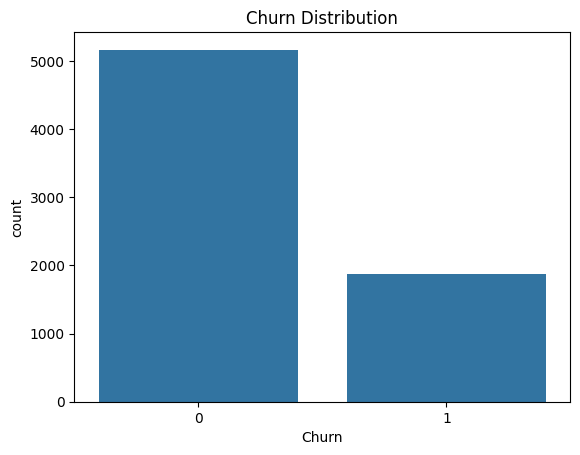

In [38]:
# Churn distribution
sns.countplot(x='Churn', data=df)
plt.title("Churn Distribution")
plt.show()

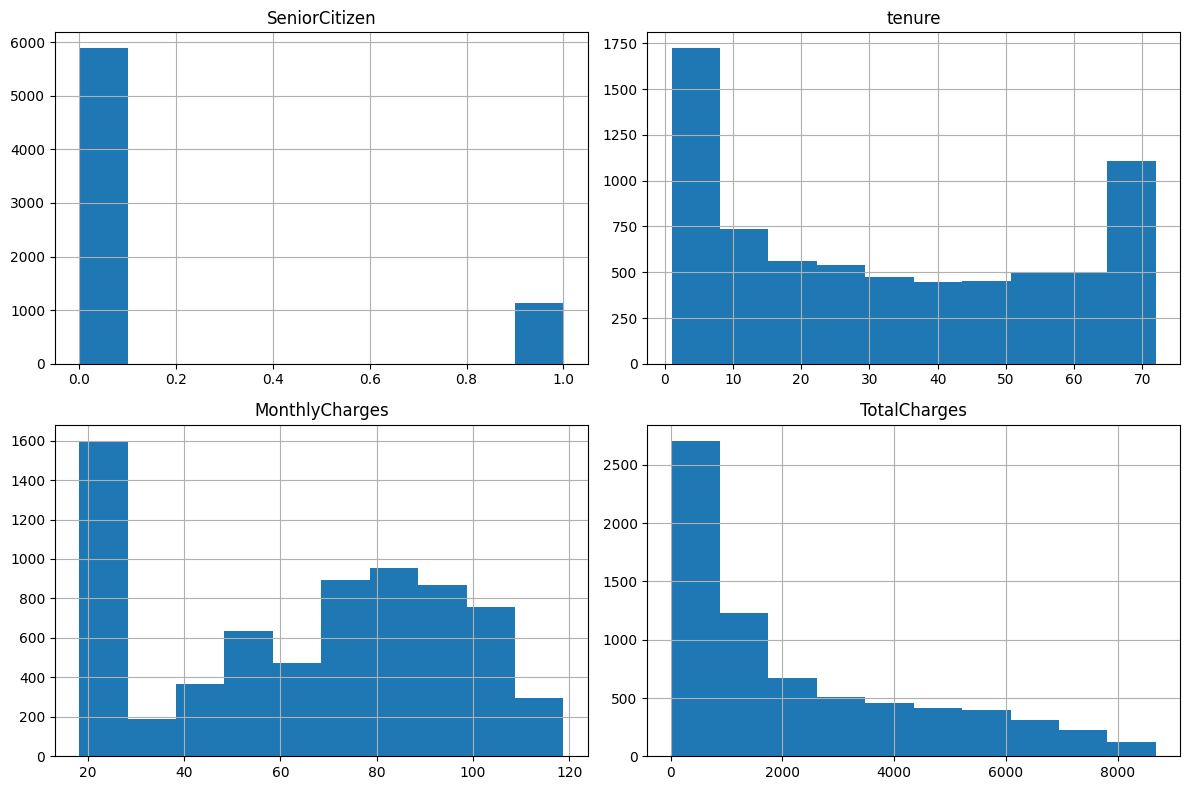

In [39]:
# Numeric feature distributions
df[num_cols].hist(figsize=(12, 8))
plt.tight_layout()
plt.show()

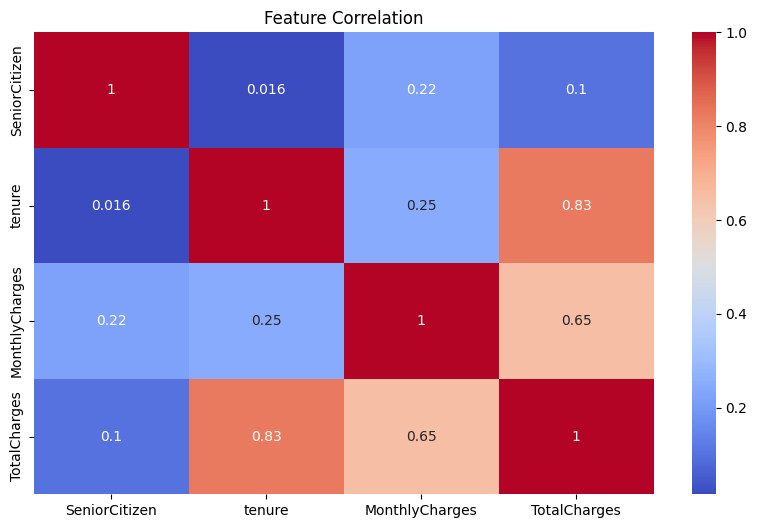

In [40]:
# Correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df[num_cols].corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation")
plt.show()

In [42]:
# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', pd.get_dummies, cat_cols)
    ],
    remainder='drop'
)


# Train Test Split - Splitting training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [44]:
from sklearn.preprocessing import OneHotEncoder

# Redefine the preprocessor with OneHotEncoder for categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ],
    remainder='drop'
)

dt_pipeline = Pipeline([
    ('prep', preprocessor),
    ('model', DecisionTreeClassifier(max_depth=6, random_state=42))
])

dt_pipeline.fit(X_train, y_train)
dt_preds = dt_pipeline.predict(X_test)
dt_f1 = f1_score(y_test, dt_preds)

In [47]:
# Model Evaluation
print("Model Evaluation:")
print("Decision Tree Accuracy:", dt_pipeline.score(X_test, y_test))
print("Decision Tree F1 Score:", dt_f1)
print("\nClassification Report:\n", classification_report(y_test, dt_preds))

Model Evaluation:
Decision Tree Accuracy: 0.7903340440653873
Decision Tree F1 Score: 0.5862552594670407

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.87      0.86      1033
           1       0.62      0.56      0.59       374

    accuracy                           0.79      1407
   macro avg       0.73      0.72      0.72      1407
weighted avg       0.78      0.79      0.79      1407



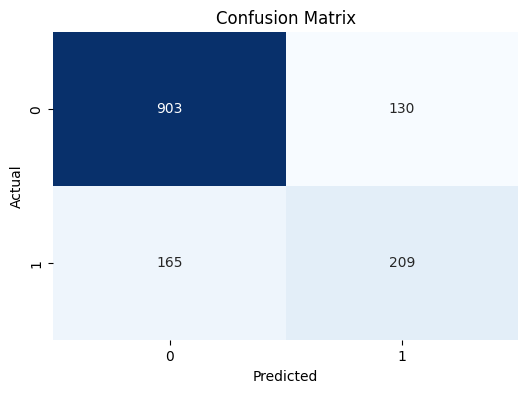

In [48]:
# Plotting Confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion matrix
cm = confusion_matrix(y_test, dt_preds)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [50]:
xgb_pipeline = Pipeline([
    ('prep', preprocessor),
    ('model', XGBClassifier(
        n_estimators=200,
        max_depth=5,
        learning_rate=0.05,
        eval_metric='logloss',
        random_state=42
    ))
])


# Training model - Fitting training data to model
xgb_pipeline.fit(X_train, y_train)

# Test Model - Make predictions on test data
xgb_preds = xgb_pipeline.predict(X_test)

In [51]:
# Model Evaluation
xgb_f1 = f1_score(y_test, xgb_preds)

print("Model Evaluation:")
print("XGBoost Accuracy:", xgb_pipeline.score(X_test, y_test))
print("XGBoost F1 Score:", xgb_f1)
print("\nClassification Report:\n", classification_report(y_test, xgb_preds))

Model Evaluation:
XGBoost Accuracy: 0.7960199004975125
XGBoost F1 Score: 0.5870503597122302

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.89      0.86      1033
           1       0.64      0.55      0.59       374

    accuracy                           0.80      1407
   macro avg       0.74      0.72      0.73      1407
weighted avg       0.79      0.80      0.79      1407



In [52]:
nn_pipeline = Pipeline([
    ('prep', preprocessor),
    ('model', MLPClassifier(
        hidden_layer_sizes=(64, 32),
        max_iter=300,
        random_state=42
    ))
])


# Train Model
nn_pipeline.fit(X_train, y_train)

# Test Model
nn_preds = nn_pipeline.predict(X_test)

# Model Evaluation
nn_f1 = f1_score(y_test, nn_preds)

In [53]:
print("Model Evaluation:")
print("Neural Network Accuracy:", nn_pipeline.score(X_test, y_test))
print("Neural Network F1 Score:", nn_f1)
print("\nClassification Report:\n", classification_report(y_test, nn_preds))

Model Evaluation:
Neural Network Accuracy: 0.7668798862828714
Neural Network F1 Score: 0.536723163841808

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.86      0.84      1033
           1       0.57      0.51      0.54       374

    accuracy                           0.77      1407
   macro avg       0.70      0.68      0.69      1407
weighted avg       0.76      0.77      0.76      1407



In [54]:
results = pd.DataFrame({
    'Model': ['Decision Tree', 'XGBoost', 'Neural Network'],
    'F1 Score': [dt_f1, xgb_f1, nn_f1]
})

results

,Model,F1 Score
0,Decision Tree,0.586255
1,XGBoost,0.587050
2,Neural Network,0.536723


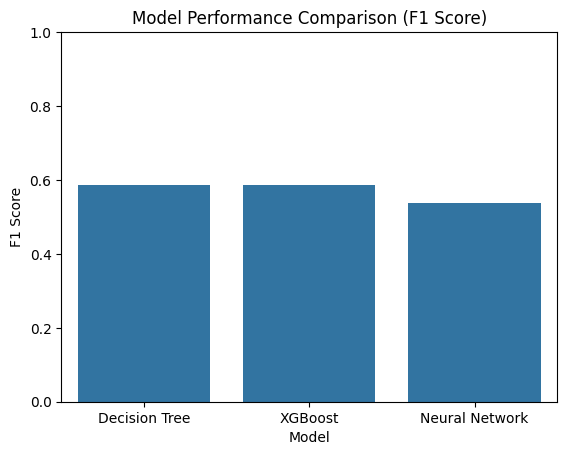

In [55]:
sns.barplot(x='Model', y='F1 Score', data=results)
plt.title("Model Performance Comparison (F1 Score)")
plt.ylim(0, 1)
plt.show()

In [58]:
best_model_name = results.sort_values('F1 Score', ascending=False).iloc[0]['Model']
best_f1 = results['F1 Score'].max()

model_map = {
    'Decision Tree': dt_pipeline,
    'XGBoost': xgb_pipeline,
    'Neural Network': nn_pipeline
}

best_model = model_map[best_model_name]

print(f"Best Model: {best_model_name} | F1: {best_f1:.4f}")

joblib.dump(best_model, "production_model.pkl")

Best Model: XGBoost | F1: 0.5871


['production_model.pkl']

In [70]:
# Take 15 random data rows from the test set
sample_indices = X_test.sample(n=15, random_state=42).index
sample_X = X_test.loc[sample_indices]
sample_y_actual = y_test.loc[sample_indices]

# Make predictions using the best model
sample_predictions = best_model.predict(sample_X)

# Create a DataFrame to display actual and predicted values
predictions_df = pd.DataFrame({
    'Actual Churn': sample_y_actual,
    'Predicted Churn': sample_predictions
})

print(predictions_df)

      Actual Churn  Predicted Churn
6970             1                1
6331             0                0
4658             0                0
3471             0                0
192              0                0
4393             1                1
1144             1                1
5712             0                0
6376             0                0
2505             0                0
1333             0                0
6148             0                0
3777             0                0
6772             1                0
1059             1                0
